In [1]:
import numpy as np
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import *
from tensorflow.python.keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.callbacks import Callback
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

(X_train, X_valid) = X_train[1000:], X_train[:1000] 
(y_train, y_valid) = y_train[1000:], y_train[:1000]


In [3]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(4*4*64, kernel_initializer='he_normal', activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
fla

In [4]:
class ValidationCallback(Callback):
    def __init__(self, val_data):
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.val_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186

    '''
    
    def __init__(self, val_data, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        self.x_val, self.y_val = val_data
        self.val_losses = []
        self.val_accs = []
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1
        
        val_loss, val_acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self, plot_title):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.title(plot_title)
        plt.plot(self.history['iterations'], self.history['lr'])
        #plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self, plot_title):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.title(plot_title)
        plt.plot(self.history['lr'], self.history['loss'], label='training loss')
        plt.plot(self.history['lr'], self.val_losses, label='validation loss')
        #plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        plt.show()
    
    def plot_acc(self, plot_title):
        '''Helper function to observe improvements in accuracy through the experiment'''
        plt.title(plot_title)
        plt.plot(self.history['lr'], self.history['acc'], label='training accuracy')
        plt.plot(self.history['lr'], self.val_accs, label='validation accuracy')
        #plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.show()
    
    def recommend_max_lr(self):
        '''Returns the maximum learning rate that can be used without overfitting'''
        
        min_val_loss_index = self.val_losses.index(min(self.val_losses))
        return self.history['lr'][min_val_loss_index]
        
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel_initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias_initializer.run(session=session)     

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 59000 samples, validate on 1000 samples
Epoch 1/2
59000/59000 [==============================] - 4015s - loss: 0.5329 - acc: 0.8089 - val_loss: 0.3305 - val_acc: 0.8930
Epoch 2/2
59000/59000 [==============================] - 1846s - loss: 0.3105 - acc: 0.8866 - val_loss: 0.3578 - val_acc: 0.8800


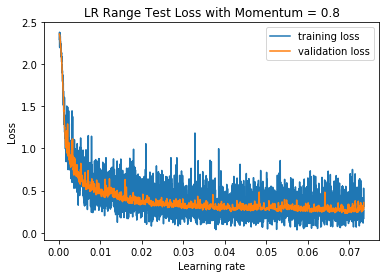

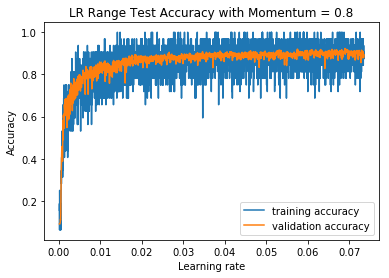

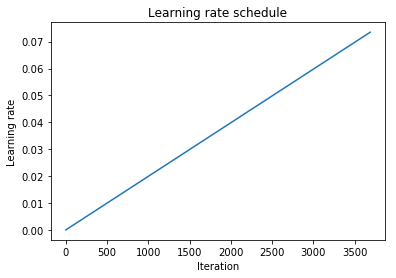

Recommended Max LR = 0.0689539983868599


In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)
EPOCH_SIZE=60000
BATCH_SIZE=120

momentum_values = [0.80]

for momentum in momentum_values:
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(4*4*64, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    lr_finder = LRFinder(min_lr=1e-4,max_lr=3e-2, 
                         steps_per_epoch=np.ceil(EPOCH_SIZE/BATCH_SIZE), 
                         epochs=2, val_data=(X_valid, y_valid))
    sgd = SGD(lr=1e-5, momentum=momentum)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=2, callbacks=[lr_finder])
    lr_finder.plot_loss(plot_title='LR Range Test Loss with Momentum = {}'.format(momentum))
    lr_finder.plot_acc(plot_title='LR Range Test Accuracy with Momentum = {}'.format(momentum))
    lr_finder.plot_lr(plot_title='Learning rate schedule')
    print('Recommended Max LR = {}'.format(lr_finder.recommend_max_lr()))

In [8]:
class CyclicLR(Callback):
    
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [11]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(4*4*64, kernel_initializer='he_normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

num_steps = np.ceil(EPOCH_SIZE/BATCH_SIZE)
max_lr = 0.06895
min_lr = 0.017
CLR = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=np.ceil(num_steps / 4))
sgd = SGD(lr=min_lr, momentum=0.8)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, callbacks=[CLR], validation_data=(X_test, y_test))

Train on 59000 samples, validate on 10000 samples
Epoch 1/10
59000/59000 [==============================] - 185s - loss: 0.4602 - acc: 0.8336 - val_loss: 0.3011 - val_acc: 0.8922
Epoch 2/10
59000/59000 [==============================] - 173s - loss: 0.2640 - acc: 0.9034 - val_loss: 0.2514 - val_acc: 0.9079
Epoch 3/10
59000/59000 [==============================] - 167s - loss: 0.2111 - acc: 0.9237 - val_loss: 0.2350 - val_acc: 0.9147
Epoch 4/10
59000/59000 [==============================] - 167s - loss: 0.1730 - acc: 0.9368 - val_loss: 0.2395 - val_acc: 0.9142
Epoch 5/10
59000/59000 [==============================] - 168s - loss: 0.1438 - acc: 0.9474 - val_loss: 0.2385 - val_acc: 0.9204
Epoch 6/10
59000/59000 [==============================] - 169s - loss: 0.1147 - acc: 0.9592 - val_loss: 0.2367 - val_acc: 0.9186
Epoch 7/10
59000/59000 [==============================] - 168s - loss: 0.0889 - acc: 0.9683 - val_loss: 0.2646 - val_acc: 0.9161
Epoch 8/10
59000/59000 [=======================